In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 150 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 150 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


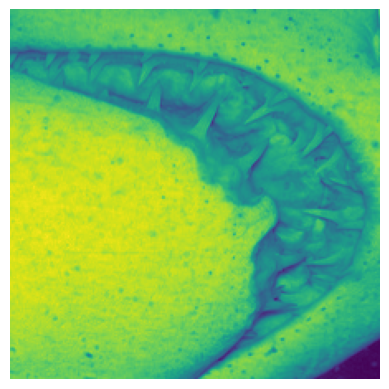

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000050, Loss: 1.3225


Epoch 1, Batch 2, LR: 0.000050, Loss: 1.3001


Epoch 1, Batch 3, LR: 0.000050, Loss: 1.0842


Epoch 1, Batch 4, LR: 0.000050, Loss: 0.9824


Epoch 1, Batch 5, LR: 0.000050, Loss: 0.9171


Epoch 1, Batch 6, LR: 0.000050, Loss: 0.8649


Epoch 1, Batch 7, LR: 0.000050, Loss: 0.8491


Epoch 1, Batch 8, LR: 0.000050, Loss: 0.8068


Epoch 1, Batch 9, LR: 0.000050, Loss: 0.7895


Epoch 1, Batch 10, LR: 0.000049, Loss: 0.7664


Epoch 1, Batch 11, LR: 0.000049, Loss: 0.7574


Epoch 1, Batch 12, LR: 0.000049, Loss: 0.7269


Epoch 1, Batch 13, LR: 0.000049, Loss: 0.7287


Epoch 1, Batch 14, LR: 0.000049, Loss: 0.7189


Epoch 1, Batch 15, LR: 0.000049, Loss: 0.7272


Epoch 1, Batch 16, LR: 0.000049, Loss: 0.7139


Epoch 1, Batch 17, LR: 0.000048, Loss: 0.7074


Epoch 1, Batch 18, LR: 0.000048, Loss: 0.6935


Epoch 1, Batch 19, LR: 0.000048, Loss: 0.6797


Epoch 1, Batch 20, LR: 0.000048, Loss: 0.6735


Epoch 1, Batch 21, LR: 0.000048, Loss: 0.6734


Epoch 1, Batch 22, LR: 0.000047, Loss: 0.6723


Epoch 1, Batch 23, LR: 0.000047, Loss: 0.6521


Epoch 1, Batch 24, LR: 0.000047, Loss: 0.6719


Epoch 1, Batch 25, LR: 0.000047, Loss: 0.6464


Epoch 1, Batch 26, LR: 0.000046, Loss: 0.6403


Epoch 1, Batch 27, LR: 0.000046, Loss: 0.6466


Epoch 1, Batch 28, LR: 0.000046, Loss: 0.6460


Epoch 1, Batch 29, LR: 0.000046, Loss: 0.6370


Epoch 1, Batch 30, LR: 0.000045, Loss: 0.6505


Epoch 1, Batch 31, LR: 0.000045, Loss: 0.6444


Epoch 1, Batch 32, LR: 0.000045, Loss: 0.6312


Epoch 1, Batch 33, LR: 0.000044, Loss: 0.6477


Epoch 1, Batch 34, LR: 0.000044, Loss: 0.6301


Epoch 1, Batch 35, LR: 0.000044, Loss: 0.6241


Epoch 1, Batch 36, LR: 0.000043, Loss: 0.6269


Epoch 1, Batch 37, LR: 0.000043, Loss: 0.6325


Epoch 1, Batch 38, LR: 0.000042, Loss: 0.6244


Epoch 1, Batch 39, LR: 0.000042, Loss: 0.6348


Epoch 1, Batch 40, LR: 0.000042, Loss: 0.5974


Epoch 1, Batch 41, LR: 0.000041, Loss: 0.6049


Epoch 1, Batch 42, LR: 0.000041, Loss: 0.6253


Epoch 1, Batch 43, LR: 0.000041, Loss: 0.6249


Epoch 1, Batch 44, LR: 0.000040, Loss: 0.5988


Epoch 1, Batch 45, LR: 0.000040, Loss: 0.6182


Epoch 1, Batch 46, LR: 0.000039, Loss: 0.6083


Epoch 1, Batch 47, LR: 0.000039, Loss: 0.6066


Epoch 1, Batch 48, LR: 0.000038, Loss: 0.6180


Epoch 1, Batch 49, LR: 0.000038, Loss: 0.6182


Epoch 1, Batch 50, LR: 0.000037, Loss: 0.6161


Epoch 1, Batch 51, LR: 0.000037, Loss: 0.6085


Epoch 1, Batch 52, LR: 0.000037, Loss: 0.6140


Epoch 1, Batch 53, LR: 0.000036, Loss: 0.6134


Epoch 1, Batch 54, LR: 0.000036, Loss: 0.6169


Epoch 1, Batch 55, LR: 0.000035, Loss: 0.6065


Epoch 1, Batch 56, LR: 0.000035, Loss: 0.5867


Epoch 1, Batch 57, LR: 0.000034, Loss: 0.6055


Epoch 1, Batch 58, LR: 0.000034, Loss: 0.6059


Epoch 1, Batch 59, LR: 0.000033, Loss: 0.6034


Epoch 1, Batch 60, LR: 0.000033, Loss: 0.6055


Epoch 1, Batch 61, LR: 0.000032, Loss: 0.6058


Epoch 1, Batch 62, LR: 0.000032, Loss: 0.6054


Epoch 1, Batch 63, LR: 0.000031, Loss: 0.6030


Epoch 1, Batch 64, LR: 0.000031, Loss: 0.6065


Epoch 1, Batch 65, LR: 0.000030, Loss: 0.5980


Epoch 1, Batch 66, LR: 0.000030, Loss: 0.6044


Epoch 1, Batch 67, LR: 0.000029, Loss: 0.5943


Epoch 1, Batch 68, LR: 0.000029, Loss: 0.6055


Epoch 1, Batch 69, LR: 0.000028, Loss: 0.5826


Epoch 1, Batch 70, LR: 0.000028, Loss: 0.5956


Epoch 1, Batch 71, LR: 0.000027, Loss: 0.6054


Epoch 1, Batch 72, LR: 0.000027, Loss: 0.5982


Epoch 1, Batch 73, LR: 0.000026, Loss: 0.5990


Epoch 1, Batch 74, LR: 0.000026, Loss: 0.5901


Epoch 1, Batch 75, LR: 0.000025, Loss: 0.6062


Epoch 1, Batch 76, LR: 0.000024, Loss: 0.5944


Epoch 1, Batch 77, LR: 0.000024, Loss: 0.5894


Epoch 1, Batch 78, LR: 0.000023, Loss: 0.6003


Epoch 1, Batch 79, LR: 0.000023, Loss: 0.5901


Epoch 1, Batch 80, LR: 0.000022, Loss: 0.5986


Epoch 1, Batch 81, LR: 0.000022, Loss: 0.5981


Epoch 1, Batch 82, LR: 0.000021, Loss: 0.5866


Epoch 1, Batch 83, LR: 0.000021, Loss: 0.6105


Epoch 1, Batch 84, LR: 0.000020, Loss: 0.6014


Epoch 1, Batch 85, LR: 0.000020, Loss: 0.5878


Epoch 1, Batch 86, LR: 0.000019, Loss: 0.5978


Epoch 1, Batch 87, LR: 0.000019, Loss: 0.5987


Epoch 1, Batch 88, LR: 0.000018, Loss: 0.5857


Epoch 1, Batch 89, LR: 0.000018, Loss: 0.5958


Epoch 1, Batch 90, LR: 0.000017, Loss: 0.6102


Epoch 1, Batch 91, LR: 0.000017, Loss: 0.5931


Epoch 1, Batch 92, LR: 0.000016, Loss: 0.5751


Epoch 1, Batch 93, LR: 0.000016, Loss: 0.5821


Epoch 1, Batch 94, LR: 0.000015, Loss: 0.5912


Epoch 1, Batch 95, LR: 0.000015, Loss: 0.5913


Epoch 1, Batch 96, LR: 0.000014, Loss: 0.5716


Epoch 1, Batch 97, LR: 0.000014, Loss: 0.5988


Epoch 1, Batch 98, LR: 0.000013, Loss: 0.5933


Epoch 1, Batch 99, LR: 0.000013, Loss: 0.5843


Epoch 1, Batch 100, LR: 0.000012, Loss: 0.6005


Epoch 1, Batch 101, LR: 0.000012, Loss: 0.6107


Epoch 1, Batch 102, LR: 0.000012, Loss: 0.5855


Epoch 1, Batch 103, LR: 0.000011, Loss: 0.6202


Epoch 1, Batch 104, LR: 0.000011, Loss: 0.5835


Epoch 1, Batch 105, LR: 0.000010, Loss: 0.5882


Epoch 1, Batch 106, LR: 0.000010, Loss: 0.5713


Epoch 1, Batch 107, LR: 0.000009, Loss: 0.5859


Epoch 1, Batch 108, LR: 0.000009, Loss: 0.6045


Epoch 1, Batch 109, LR: 0.000009, Loss: 0.5899


Epoch 1, Batch 110, LR: 0.000008, Loss: 0.5983


Epoch 1, Batch 111, LR: 0.000008, Loss: 0.5758


Epoch 1, Batch 112, LR: 0.000008, Loss: 0.5928


Epoch 1, Batch 113, LR: 0.000007, Loss: 0.6158


Epoch 1, Batch 114, LR: 0.000007, Loss: 0.5907


Epoch 1, Batch 115, LR: 0.000006, Loss: 0.6016


Epoch 1, Batch 116, LR: 0.000006, Loss: 0.5883


Epoch 1, Batch 117, LR: 0.000006, Loss: 0.5928


Epoch 1, Batch 118, LR: 0.000005, Loss: 0.5912


Epoch 1, Batch 119, LR: 0.000005, Loss: 0.5883


Epoch 1, Batch 120, LR: 0.000005, Loss: 0.5911


Epoch 1, Batch 121, LR: 0.000004, Loss: 0.6014


Epoch 1, Batch 122, LR: 0.000004, Loss: 0.5871


Epoch 1, Batch 123, LR: 0.000004, Loss: 0.5739


Epoch 1, Batch 124, LR: 0.000004, Loss: 0.5991


Epoch 1, Batch 125, LR: 0.000003, Loss: 0.5964


Epoch 1, Batch 126, LR: 0.000003, Loss: 0.5907


Epoch 1, Batch 127, LR: 0.000003, Loss: 0.5833


Epoch 1, Batch 128, LR: 0.000003, Loss: 0.5921


Epoch 1, Batch 129, LR: 0.000002, Loss: 0.5754


Epoch 1, Batch 130, LR: 0.000002, Loss: 0.5759


Epoch 1, Batch 131, LR: 0.000002, Loss: 0.5890


Epoch 1, Batch 132, LR: 0.000002, Loss: 0.5846


Epoch 1, Batch 133, LR: 0.000002, Loss: 0.5786


Epoch 1, Batch 134, LR: 0.000001, Loss: 0.5993


Epoch 1, Batch 135, LR: 0.000001, Loss: 0.5791


Epoch 1, Batch 136, LR: 0.000001, Loss: 0.5894


Epoch 1, Batch 137, LR: 0.000001, Loss: 0.5804


Epoch 1, Batch 138, LR: 0.000001, Loss: 0.5948


Epoch 1, Batch 139, LR: 0.000001, Loss: 0.5985


Epoch 1, Batch 140, LR: 0.000001, Loss: 0.5927


Epoch 1, Batch 141, LR: 0.000000, Loss: 0.5906


Epoch 1, Batch 142, LR: 0.000000, Loss: 0.5946


Epoch 1, Batch 143, LR: 0.000000, Loss: 0.5991


Epoch 1, Batch 144, LR: 0.000000, Loss: 0.5921


Epoch 1, Batch 145, LR: 0.000000, Loss: 0.5880


Epoch 1, Batch 146, LR: 0.000000, Loss: 0.5977


Epoch 1, Batch 147, LR: 0.000000, Loss: 0.5943


Epoch 1, Batch 148, LR: 0.000000, Loss: 0.5860


Epoch 1, Batch 149, LR: 0.000000, Loss: 0.5995


Epoch 1, Batch 150, LR: 0.000000, Loss: 0.5873


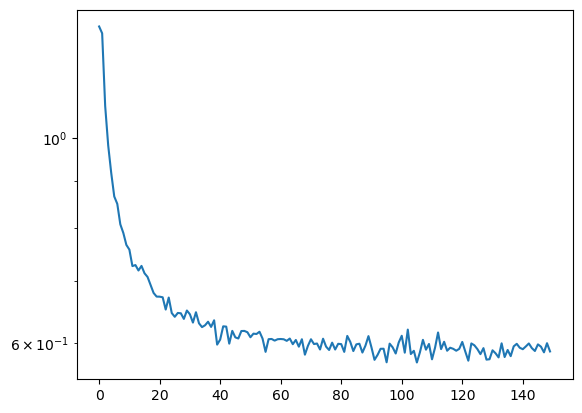

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.05s/it]

 20%|██        | 2/10 [00:02<00:08,  1.05s/it]

 30%|███       | 3/10 [00:03<00:07,  1.04s/it]

 40%|████      | 4/10 [00:04<00:06,  1.07s/it]

 50%|█████     | 5/10 [00:05<00:05,  1.05s/it]

 60%|██████    | 6/10 [00:06<00:04,  1.15s/it]

 70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

 80%|████████  | 8/10 [00:08<00:02,  1.09s/it]

 90%|█████████ | 9/10 [00:09<00:01,  1.11s/it]

100%|██████████| 10/10 [00:10<00:00,  1.11s/it]

100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

Test Loss: 0.5728


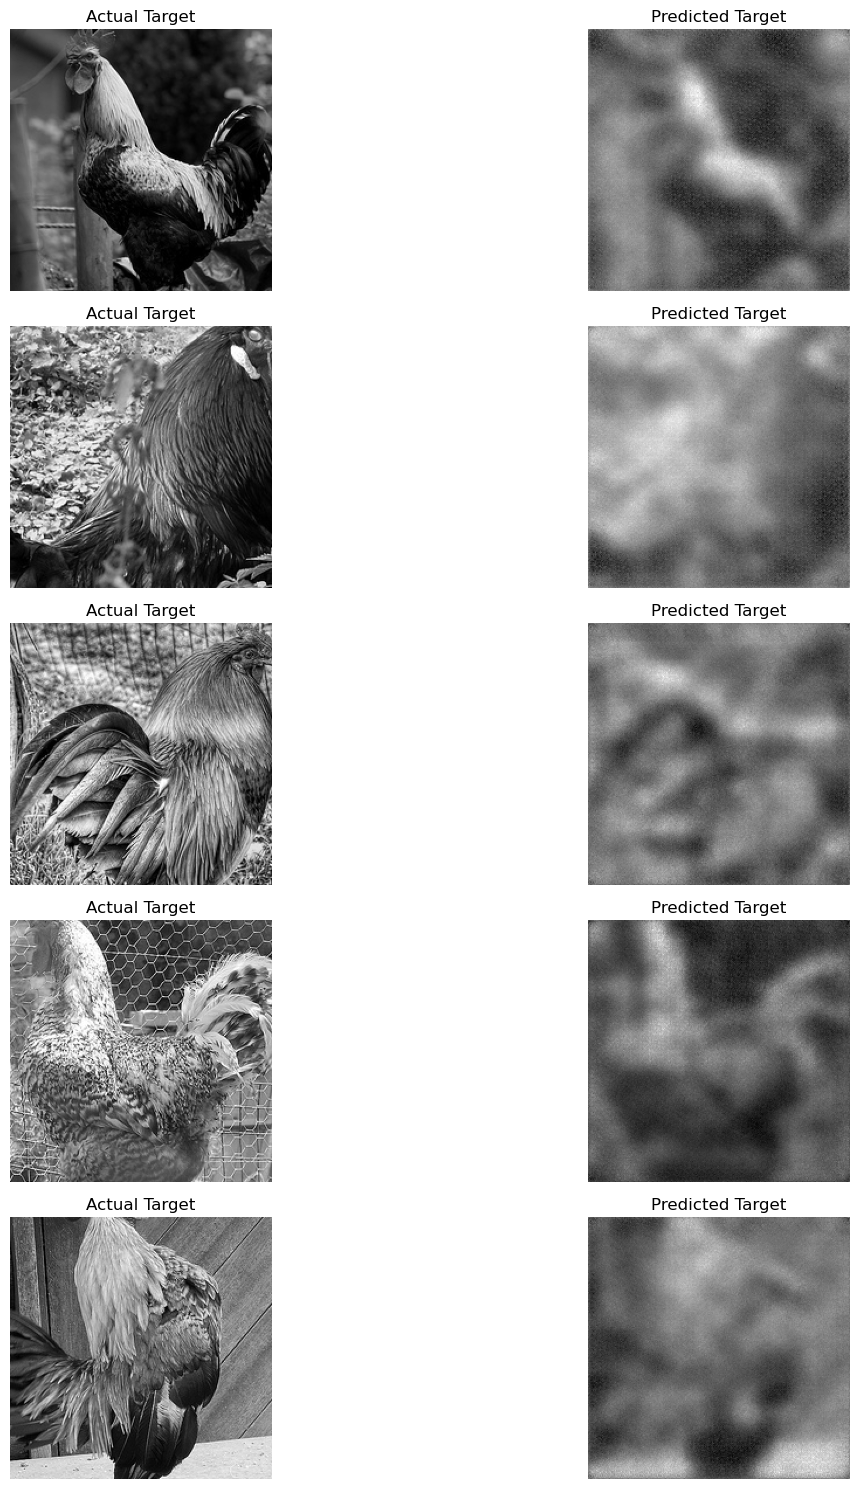

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-4.1016) tensor(8.0628)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))